# SNN鸢尾花分类-全前向训练-ANN转SNN

代码说明：先使用基于扰动的方法训练ANN然后转为SNN

作者：复旦大学 微电子学院 赵振宇

In [131]:
# 引入库
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from spikingjelly.activation_based import neuron, encoding, functional, surrogate, ann2snn
from spikingjelly import visualizing
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torchsummary import summary # 用于预览神经网络结构的库
import time
import csv

In [132]:
# 配置基本信息
# 配置运行硬件平台
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")
# 指定数据集地址
dataset_dir = "./dataset" # 数据集地址
# 指定数据集的batch_size
batch_size = 30
# 设定自动保存模型的地址
model_auto_save_dir = "./model_save/auto_save/"
# 设定手动保存模型的地址
model_history_save_dir = "./model_save/history_save/"
# 设定外部图片地址
# 请务必确保对应文件夹中有该图片
img_path = "./dataset/images1.jpg"
# jupyter输出不打印省略号
torch.set_printoptions(threshold=np.inf)

device: cuda:0


In [133]:
# 将鸢尾花数据集转换为DataLoader
# 自定义 Dataset 类
class IrisDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.features = []
        self.labels = []
        self.transform = transform
        
        # 读取 CSV 文件
        with open(csv_file, 'r') as f:
            reader = csv.reader(f)
            next(reader)  # 跳过表头
            for row in reader:
                # 前四列为特征，最后一列为标签
                feature = list(map(float, row[:-1]))
                label = row[-1]
                # 将标签转换为数值
                if label == 'setosa':
                    label = 0
                elif label == 'versicolor':
                    label = 1
                elif label == 'virginica':
                    label = 2
                else:
                    raise ValueError(f"未知的标签: {label}")
                self.features.append(feature)
                self.labels.append(label)
        
        # 转换为张量
        self.features = torch.FloatTensor(self.features)
        self.labels = torch.tensor(self.labels, dtype=torch.int64)

        # 将特征值归一化
        self.features = F.normalize(self.features, p=float('inf'), dim=1)
    
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        # 返回特征和标签
        return self.features[idx], self.labels[idx]


# 设置文件路径
train_csv_path = "./dataset/iris_train.csv" # 替换为你的训练集 CSV 文件路径
test_csv_path = "./dataset/iris_test.csv"    # 替换为你的测试集 CSV 文件路径

# 创建 Dataset
train_dataset = IrisDataset(train_csv_path)
test_dataset = IrisDataset(test_csv_path)

# 打印训练数据集长度
train_dataset_size = len(train_dataset)
print(train_dataset_size)
# 打印测试数据集长度
test_dataset_size = len(test_dataset)
print(test_dataset_size)

# 创建 DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

120
30


In [134]:
# DataLoader测试
for data in test_dataloader:
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    # print(f"inputs = {inputs}")
    # print(f"labels = {labels}")

In [135]:
# 定义网络架构
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear_1 = nn.Linear(4, 4, bias=False)
        self.relu = nn.ReLU()
        self.linear_2 = nn.Linear(4, 3, bias=False)

    def forward(self, x):
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.linear_2(x)
        x = self.relu(x)
        return x
    
# 实例化神经网络
net = Net()
net = net.to(device) # 将神经网络转换
# 加载之前训练过的网络
# net = torch.load("net_CIFAR10.pth")

# 打印神经网络信息
print("神经网络信息")
print(net)

# 测试神经网络的输出格式
# 设置满足要求的输入
input = torch.ones([4])
input = input.to(device)
print("输入数据格式", input.shape)

output = net(input)
print("输出数据格式", output.shape)

# 查看神经网络模型大小
summary(net, input_size=[[1, 4]])

神经网络信息
Net(
  (linear_1): Linear(in_features=4, out_features=4, bias=False)
  (relu): ReLU()
  (linear_2): Linear(in_features=4, out_features=3, bias=False)
)
输入数据格式 torch.Size([4])
输出数据格式 torch.Size([3])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 4]              16
              ReLU-2                 [-1, 1, 4]               0
            Linear-3                 [-1, 1, 3]              12
              ReLU-4                 [-1, 1, 3]               0
Total params: 28
Trainable params: 28
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [136]:
# 设置神经网络超参数
# 设置损失函数
loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device) # 将损失函数转换

# 设置训练超参数
perturbation = 0.005 # 设置扰动量

In [137]:
# 使用DataLoader时候，一定要注意，batch_size一定要大于1，
# 因为要确保有多个数据输入到一次前向传播中，来保证扰动的优化方向是一个平均方向
# 而不只是会因为某一个数据而决定优化方向

# 全前向训练算法
def full_forward_training(net, inputs, labels, perturbation):
    # 定义变化量存储数组
    delta_array = np.zeros((2, 4, 4))
    # 将NumPy数组转换为PyTorch张量
    delta_array = torch.from_numpy(delta_array)
    # 适应设备
    delta_array = delta_array.to(device)

    # 遍历模型中的每个参数
    layer = 0
    for param in net.parameters():
        for i in range(param.data.shape[0]):
            for j in range(param.data.shape[1]):
                # 保存原始权重参数值
                original_value = param.data[i][j].clone().to(device)
            
                # 增加扰动权重参数
                param.data[i][j] += perturbation
                # 前向传播
                outputs = net(inputs)
                # 计算新的loss函数
                new_loss_plus = loss_fn(outputs, labels)

                # 恢复到原始参数值
                param.data[i][j] = original_value
                # 减小扰动权重参数
                param.data[i][j] -= perturbation
                # 前向传播
                outputs = net(inputs)
                # 计算新的loss函数
                new_loss_minus = loss_fn(outputs, labels)

                # 选择使loss最小的权重参数值存储在数组中
                if(new_loss_plus < new_loss_minus):
                    delta_array[layer][i][j] = original_value + perturbation
                elif(new_loss_plus > new_loss_minus):
                    delta_array[layer][i][j] = original_value - perturbation
                else:
                    delta_array[layer][i][j] = original_value
                
                # # 输出原始的loss
                # print(f"original_loss:{original_loss}")
                # # 输出增加扰动的loss
                # print(f"new_loss_plus:{new_loss_plus}")
                # # 输出减小扰动的loss
                # print(f"new_loss_minus:{new_loss_minus}")

                # # 输出原始权重参数
                # print(f"original_value[{i}][{j}]:{original_value}")
                # # 输出训练后的权重参数
                # print(f"更新后的param[{i}][{j}]:{param.data[i][j]}")

                # # 单个变量训练结束
                # print("---------")
        layer += 1 # delta_array的layer索引加一
    
    # 更新权重参数值
    layer = 0
    for param in net.parameters():
        for i in range(param.data.shape[0]):
            for j in range(param.data.shape[1]):
                param.data[i][j] = delta_array[layer][i][j]
        layer += 1 # delta_array的layer索引加一

In [138]:
# 设定训练轮数
epoch = 500
epoch_show = 50 # 每epoch_show次展示输出结果
# 定义训练集loss以及准确率变量
loss_train = 0.0 # 训练损失值
loss_train_sum = 0.0 # 训练损失值累加值
loss_train_mean = 0.0 # 这一轮训练损失值的平均值
loss_train_store = np.zeros(epoch) # 训练损失值存储数组
accuracy_train = 0 # 训练准确数
accuracy_rate_train = 0.0 # 训练准确率
accuracy_rate_train_max = 0.0 # 最大训练准确率
accuracy_rate_train_store = np.zeros(epoch) # 训练准确率存储素数组
# 定义交叉验证集loss以及准确率变量
loss_cv = 0.0 # 验证损失值
loss_cv_sum = 0.0 # 验证损失值累加值
loss_cv_mean = 0.0 # 这一轮验证损失值的平均值
loss_cv_store = np.zeros(epoch) # 验证损失值存储数组
accuracy_cv = 0 # 验证准确数
accuracy_rate_cv = 0.0 # 验证准确率
accuracy_rate_cv_max = 0.0 # 最大验证准确率
accuracy_rate_cv_store = np.zeros(epoch) # 验证准确率存储素数组

In [141]:
# 训练ANN网络

#########################开始训练########################

for i in range(epoch):
    if(i % epoch_show == 0): # 每50次输出
        print("-----------第%d轮训练开始------------" %i)
    # 每轮loss累加值清零
    loss_train_sum = 0
    loss_cv_sum = 0
    # 开始训练神经网络
    net.train()
    # 这一轮的训练计数
    train_step = 0
    # 准确性变量清零
    accuracy_train = 0
    for data in train_dataloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 输入神经网络并运行
        output = net(inputs)

        # 计算损失函数
        loss_train = loss_fn(output, labels)
        # 累加损失函数
        loss_train_sum += loss_train.item()
        # 将分类概率转化为对应标签
        pred_label = output.argmax(1)
        # 累加计算结果准确性
        accuracy_train += (pred_label == labels).sum()
        # 全前向训练
        full_forward_training(net, inputs, labels, perturbation)

    # 计算训练集损失函数loss train
    loss_train_mean = loss_train_sum / (train_dataset_size/batch_size)
    loss_train_store[i] = loss_train_mean
    # 计算训练集准确率
    accuracy_rate_train = (accuracy_train/train_dataset_size) * 100
    accuracy_rate_train_store[i] = accuracy_rate_train
    
    
    # 开始测试神经网络
    net.eval()
    # 总测试次数
    test_step = 0
    # 准确性变量清零
    accuracy_cv = 0
    with torch.no_grad(): # 预测阶段不进行梯度下降
        for data in test_dataloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)  

            # 输入神经网络并运行
            output = net(inputs)
            # 计算损失函数
            loss_cv = loss_fn(output, labels)
            # 累加损失函数
            loss_cv_sum += loss_cv.item()
            # 将分类概率转化为对应标签
            pred_label = output.argmax(1)
            # 累加计算结果准确性
            accuracy_cv += (pred_label == labels).sum()
            test_step += 1

    # 计算交叉验证集损失函数loss cv
    loss_cv_mean = loss_cv_sum / (test_dataset_size/batch_size)
    loss_cv_store[i] = loss_cv_mean
    # 计算交叉验证集准确率
    accuracy_rate_cv = (accuracy_cv/test_dataset_size) * 100
    accuracy_rate_cv_store[i] = accuracy_rate_cv
    # 输出该轮训练结果
    if(i % epoch_show == 0): # 每epoch_show次输出
        print("loss train: %.5f, accuracy rate train: %.5f%%, loss cv: %.5f, accuracy rate cv: %.5f%%" %(loss_train_mean, accuracy_rate_train.item(), loss_cv_mean, accuracy_rate_cv.item()))
        # 自动保存训练过程中准确率大于之前的神经网络模型
        if (accuracy_rate_train + accuracy_rate_cv > accuracy_rate_train_max + accuracy_rate_cv_max):
            torch.save(net, model_auto_save_dir + "model_auto_save_acc%d.pth" %accuracy_rate_cv)
            accuracy_rate_train_max = accuracy_rate_train # 记录最大训练准确率
            accuracy_rate_cv_max = accuracy_rate_cv # 记录最大训练准确率

#########################结束训练########################
print("-------------------------------训练完成-------------------------------")

-----------第0轮训练开始------------
loss train: 0.44903, accuracy rate train: 66.66667%, loss cv: 0.38917, accuracy rate cv: 66.66667%
-----------第50轮训练开始------------
loss train: 0.44752, accuracy rate train: 66.66667%, loss cv: 0.39307, accuracy rate cv: 66.66667%
-----------第100轮训练开始------------
loss train: 0.44683, accuracy rate train: 66.66667%, loss cv: 0.39294, accuracy rate cv: 66.66667%
-----------第150轮训练开始------------
loss train: 0.44882, accuracy rate train: 66.66667%, loss cv: 0.38897, accuracy rate cv: 66.66667%
-----------第200轮训练开始------------
loss train: 0.44770, accuracy rate train: 66.66667%, loss cv: 0.38622, accuracy rate cv: 66.66667%
-----------第250轮训练开始------------
loss train: 0.44886, accuracy rate train: 66.66667%, loss cv: 0.38749, accuracy rate cv: 66.66667%
-----------第300轮训练开始------------
loss train: 0.44432, accuracy rate train: 66.66667%, loss cv: 0.39701, accuracy rate cv: 66.66667%
-----------第350轮训练开始------------
loss train: 0.23548, accuracy rate train: 96.6

---------损失函数Loss随训练轮数epoch的变化图像---------


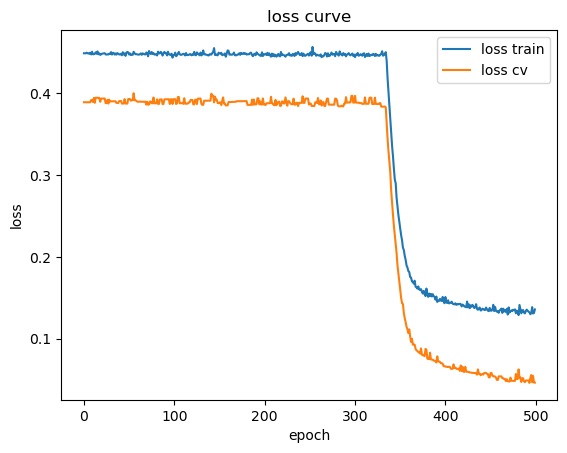

---------准确率accuracy随训练轮数epoch的变化图像---------


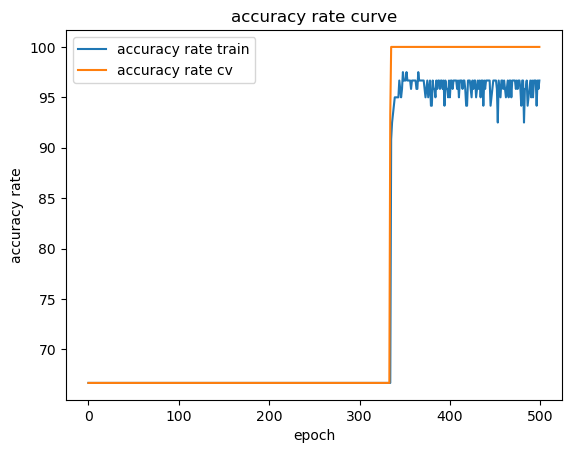

In [142]:
# 画出loss曲线
print("---------损失函数Loss随训练轮数epoch的变化图像---------")
plt.plot(np.arange(epoch), loss_train_store, np.arange(epoch), loss_cv_store)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["loss train", "loss cv"])
plt.title("loss curve")
plt.show()

# 画出accuracy曲线
print("---------准确率accuracy随训练轮数epoch的变化图像---------")
plt.plot(np.arange(epoch), accuracy_rate_train_store, np.arange(epoch), accuracy_rate_cv_store)
plt.xlabel("epoch")
plt.ylabel("accuracy rate")
plt.legend(["accuracy rate train", "accuracy rate cv"])
plt.title("accuracy rate curve")
plt.show()

In [145]:
# 加载某一轮训练的模型进行预测
# net = torch.load("model_save/auto_save/model_auto_save_acc100.pth")
# net = torch.load("model_save/history_save/model_save_acc100.pth")

# 开始使用神经网络预测
net.eval()
# 总测试次数
test_step = 0
# 统计准确性
accuracy = 0
with torch.no_grad(): # 预测阶段不进行梯度下降
    for data in test_dataloader:
        inputs, labels = data
        inputs = inputs.to(device) # 将数据转换
        labels = labels.to(device) # 将数据转换
        
        # 输入神经网络并运行
        output = net(inputs)
        # 将分类概率转化为对应标签
        pred_label = output.argmax(1)
        # 每1次输出结果
        if (test_step%1==0):
            print("输出结果", pred_label)
            print("原始标签", labels)
        # 累加计算结果准确性
        accuracy += (pred_label == labels).sum()
        test_step += 1

accuracy_rate = accuracy/test_dataset_size
print("模型预测正确数", accuracy.item(), "模型测试总数", test_dataset_size)
print("模型预测准确率: %.2f%%" %(accuracy_rate.item()*100))

输出结果 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2], device='cuda:0')
原始标签 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2], device='cuda:0')
模型预测正确数 30 模型测试总数 30
模型预测准确率: 100.00%


In [147]:
# 查看网络参数
print(net)
net.named_parameters()
for name, param in net.named_parameters(prefix="mynet"):
    print(name, param)
    print(name, param.size())

Net(
  (linear_1): Linear(in_features=4, out_features=4, bias=False)
  (relu): ReLU()
  (linear_2): Linear(in_features=4, out_features=3, bias=False)
)
mynet.linear_1.weight Parameter containing:
tensor([[-1.1581, -1.2424,  2.4262,  4.5070],
        [-0.1284,  0.1030, -0.0358,  0.2503],
        [-0.0068,  1.2077,  4.1214,  5.8169],
        [ 0.5856,  2.5572, -1.1011, -1.9647]], device='cuda:0',
       requires_grad=True)
mynet.linear_1.weight torch.Size([4, 4])
mynet.linear_2.weight Parameter containing:
tensor([[-4.4306,  0.2480, -1.2134, 10.7806],
        [-0.0936,  0.0462,  1.0904,  1.7122],
        [ 2.0456, -0.2265,  1.3258, -8.9567]], device='cuda:0',
       requires_grad=True)
mynet.linear_2.weight torch.Size([3, 4])


In [148]:
# ANN转化为SNN
net_converter = ann2snn.Converter(mode='max', dataloader=test_dataloader)
net_snn = net_converter(net)

# 查看SNN结构
net_snn

100%|██████████| 1/1 [00:00<00:00, 307.82it/s]


Net(
  (linear_1): Linear(in_features=4, out_features=4, bias=False)
  (linear_2): Linear(in_features=4, out_features=3, bias=False)
  (snn tailor): Module(
    (0): Module(
      (0): VoltageScaler(0.156179)
      (1): IFNode(
        v_threshold=1.0, v_reset=None, detach_reset=False, step_mode=s, backend=torch
        (surrogate_function): Sigmoid(alpha=4.0, spiking=True)
      )
      (2): VoltageScaler(6.402917)
    )
    (1): Module(
      (0): VoltageScaler(0.051624)
      (1): IFNode(
        v_threshold=1.0, v_reset=None, detach_reset=False, step_mode=s, backend=torch
        (surrogate_function): Sigmoid(alpha=4.0, spiking=True)
      )
      (2): VoltageScaler(19.370768)
    )
  )
)

In [149]:
# 设置SNN超参数

# 定义输入数据编码器
encoder = encoding.PoissonEncoder()

# 设定仿真时长T
T = 30

In [194]:
# 加载某一轮训练的模型进行预测
# module = torch.load("module_save/auto_save/module_auto_save_99.pth")
# module = torch.load("module_save/history_save/module_save_acc63.pth")

# 开始使用神经网络预测
net_snn.eval()
# 总测试次数
test_step = 0
# 统计准确性
accuracy = 0
with torch.no_grad(): # 预测阶段不进行梯度下降
    for data in test_dataloader:
        inputs, labels = data
        inputs = inputs.to(device) # 将数据转换
        labels = labels.to(device) # 将数据转换
        label_onehot = F.one_hot(labels, 3).float()
        out_fr = 0.0
        for t in range(T):
            encoded_inputs = encoder(inputs)
            out_fr += net_snn(encoded_inputs) # 输入数据为编码后的脉冲数据
        output = out_fr / T
        # print(output)
        # 将分类概率转化为对应标签
        pred_label = output.argmax(1)
        # 每1次输出结果
        if (test_step%1==0):
            print("输出结果", pred_label)
            print("原始标签", labels)
        # 累加计算结果准确性
        accuracy += (pred_label == labels).sum()
        test_step += 1

        # 优化一次参数后，需要重置网络的状态，因为SNN的神经元是有“记忆”的
        functional.reset_net(net_snn)

accuracy_rate = accuracy/test_dataset_size
print("模型预测正确数", accuracy.item(), "模型测试总数", test_dataset_size)
print("模型预测准确率: %.2f%%" %(accuracy_rate.item()*100))

输出结果 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 1, 1, 1, 1], device='cuda:0')
原始标签 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2], device='cuda:0')
模型预测正确数 24 模型测试总数 30
模型预测准确率: 80.00%


In [ ]:
# 保存神经网络模型
# torch.save(net, "model_save/history_save/model_save_acc.pth")
# print("模型已保存")

模型已保存


In [178]:
# 查看网络参数
print(net_snn)
net_snn.named_parameters()
for name, param in net_snn.named_parameters(prefix="mynet"):
    print(name, param)
    print(name, param.size())

Net(
  (linear_1): Linear(in_features=4, out_features=4, bias=False)
  (linear_2): Linear(in_features=4, out_features=3, bias=False)
  (snn tailor): Module(
    (0): Module(
      (0): VoltageScaler(0.156179)
      (1): IFNode(
        v_threshold=1.0, v_reset=None, detach_reset=False, step_mode=s, backend=torch
        (surrogate_function): Sigmoid(alpha=4.0, spiking=True)
      )
      (2): VoltageScaler(6.402917)
    )
    (1): Module(
      (0): VoltageScaler(0.051624)
      (1): IFNode(
        v_threshold=1.0, v_reset=None, detach_reset=False, step_mode=s, backend=torch
        (surrogate_function): Sigmoid(alpha=4.0, spiking=True)
      )
      (2): VoltageScaler(19.370768)
    )
  )
)



def forward(self, x):
    linear_1 = self.linear_1(x);  x = None
    snn_tailor_0_1 = getattr(getattr(getattr(self, "snn tailor"), "0"), "0")(linear_1);  linear_1 = None
    snn_tailor_0_2 = getattr(getattr(getattr(self, "snn tailor"), "0"), "1")(snn_tailor_0_1);  snn_tailor_0_1 = None
    snn_

In [20]:
# 清除显存
torch.cuda.empty_cache()